In [1]:
import os
import cv2
from time import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
from dask import delayed

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [3]:
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [7]:
from logistic import logistic_fit, logistic, logistic_prob

In [4]:
import dill

In [ ]:
dill.dump_session('notebook_env.db')

In [5]:
t_start = time()
dill.load_session('notebook_env.db')
time() - t_start

111053.47970986366

# Get filenames

## Testing data

In [8]:
test_face_names = sorted(glob(os.path.join('data/tests', '*.jpg')))
n_test = len(test_face_names)

In [26]:
b_inds = []
w_inds = []
for i in range(len(test_face_names)):
    if int(test_face_names[i].split('_')[2]) is 0: # race is white
        w_inds.append(i)
    else:
        b_inds.append(i)

In [17]:
test_nonface_names = sorted(glob(os.path.join('data/testing_nonfaces', '*.jpg')))
n_nonfaces_test = len(test_nonface_names)

In [16]:
faces_t = []
for i in range(n_test):
    faces_t.append(cv2.imread(test_face_names[i], cv2.IMREAD_GRAYSCALE))

In [20]:
nonfaces_t = []
for i in range(n_test):
    # Read a random nonface file
    j = random.randint(0, n_nonfaces_test - 1)
    nonface = cv2.imread(test_nonface_names[j], cv2.IMREAD_GRAYSCALE)
    
    wsize = random.randint(36, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces_t.append(crop)

In [27]:
images_t = faces_t + nonfaces_t
len(images_t)

600

## Training data

In [11]:
face_filenames0 = sorted(glob(os.path.join('data/train_0', '*.jpg')))
num_face_filenames0 = len(face_filenames0)
num_face_filenames0

4020

In [49]:
face_filenames25 = sorted(glob(os.path.join('data/train_25', '*.jpg')))
num_face_filenames25 = len(face_filenames25)
num_face_filenames25

4020

In [50]:
face_filenames50 = sorted(glob(os.path.join('data/train_50', '*.jpg')))
num_face_filenames50 = len(face_filenames50)
num_face_filenames50

4020

In [51]:
face_filenames75 = sorted(glob(os.path.join('data/train_75', '*.jpg')))
num_face_filenames75 = len(face_filenames75)
num_face_filenames75

4020

In [52]:
face_filenames100 = sorted(glob(os.path.join('data/train_100', '*.jpg')))
num_face_filenames100 = len(face_filenames100)
num_face_filenames100

4020

In [33]:
count = 0
for f in face_filenames0:
    if int(f.split('_')[3]) is 0: # race is white
        count += 1
count

4020

In [12]:
nonface_filenames = sorted(glob(os.path.join('data/training_nonfaces', '*.jpg')))
num_nonface_filenames = len(nonface_filenames)
num_nonface_filenames

250

In [38]:
n = 300

In [40]:
nonfaces = []
for i in range(n):
    # Read a random nonface file
    j = random.randint(0, num_nonface_filenames - 1)
    nonface = cv2.imread(nonface_filenames[j], cv2.IMREAD_GRAYSCALE)
    
    wsize = random.randint(50, min(nonface.shape[0], nonface.shape[1]))
    row = random.randint(0, nonface.shape[0]-wsize)
    col = random.randint(0, nonface.shape[1]-wsize)
    crop = nonface[row:row+wsize, col:col+wsize]

    # Resize to be the right size
    crop = cv2.resize(crop, (200, 200))
    nonfaces.append(crop)

In [67]:
def proportion_b(facenames):
    count = 0
    for i in range(n):
        if int(facenames[i].split('_')[3]) == 0:
            count += 1
    return count / n

In [71]:
for f in [face_filenames0, face_filenames25, face_filenames50, face_filenames75, face_filenames100]:
    print(proportion_b(f))

1.0
0.83
0.5966666666666667
0.31
0.0


In [55]:
def getimgs(facefiles):
    faces = []
    for i in range(n):
        faces.append(cv2.imread(facefiles[i], cv2.IMREAD_GRAYSCALE))
    return faces + nonfaces

In [39]:
faces0 = []
for i in range(n):
    faces0.append(cv2.imread(face_filenames0[i], cv2.IMREAD_GRAYSCALE))

# Extract Haar features

In [24]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    img = cv2.resize(img, (36,36))
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

In [58]:
X = delayed(extract_feature_image(img, feature_types) for img in images[:20])
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='threads'))
time() - t_start

126.29814195632935

In [60]:
X.shape

(20, 430920)

In [41]:
images0 = faces0 + nonfaces
len(images0)

600

In [29]:
image0 = cv2.resize(images0[0], (36,36))

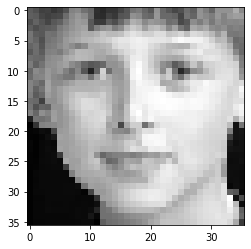

In [30]:
plt.imshow(image0, cmap='gray')

In [31]:
t = time()
image0_ = draw_haar_like_feature(integral_image(image0), 0, 0,
                                 36,36, 
                                 haar_like_feature_coord(36,36,feature_type=['type-2-x', 'type-2-y'])[0])
time() - t

58.41193127632141

In [34]:
image0_.shape

(36, 36, 3)

In [32]:
feature_types = ['type-2-x', 'type-2-y']

## testing X

In [35]:
# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X_t = delayed(extract_feature_image(img, feature_types) for img in images_t)
# Compute the result
t_start = time()
X_t = np.array(X_t.compute(scheduler='threads'))
time() - t_start

5408.295030117035

In [33]:
y_t = np.array([1] * n_test + [0] * n_test)

In [36]:
dill.dump_session('notebook_env.db')

## training X

In [42]:
len(images0)

600

In [43]:
# Build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images0)
# Compute the result
t_start = time()
X = np.array(X.compute(scheduler='threads'))
time() - t_start

6365.775489807129

In [53]:
X0 = X

In [59]:
def getx(facefiles):
    ims = getimgs(facefiles)
    X = delayed(extract_feature_image(img, feature_types) for img in ims)
    return np.array(X.compute(scheduler='threads'))

In [60]:
t_start = time()
X25 = getx(face_filenames25)
time() - t_start

8617.74287700653

In [61]:
t_start = time()
X50 = getx(face_filenames50)
time() - t_start

9534.854122877121

In [62]:
t_start = time()
X75 = getx(face_filenames75)
time() - t_start

7341.787719964981

In [63]:
t_start = time()
X100 = getx(face_filenames100)
time() - t_start

8270.294086933136

In [45]:
y = np.array([1] * n + [0] * n)

In [64]:
dill.dump_session('notebook_env.db')

# Classification

In [46]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X, y)
time() - t_start

13.200968980789185

In [8]:
y_t = [1]*len(faces_t) + [0]*len(nonfaces_t)

In [68]:
print(clf.score(X_t,y_t))

0.9416666666666667


### 0%

In [6]:
# Train a random forest classifier and assess its performance
rf0 = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
rf0.fit(X0, y)
time() - t_start

45.04568600654602

In [9]:
print(rf0.score(X_t,y_t))

0.94


### 25%

In [10]:
# Train a random forest classifier and assess its performance
rf25 = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
rf25.fit(X25, y)
time() - t_start

45.97716307640076

In [11]:
print(rf25.score(X_t,y_t))

0.94


### 50%

In [12]:
# Train a random forest classifier and assess its performance
rf50 = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
rf50.fit(X50, y)
time() - t_start

49.857863903045654

In [13]:
print(rf50.score(X_t,y_t))

0.9516666666666667


### 75%

In [14]:
# Train a random forest classifier and assess its performance
rf75 = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
rf75.fit(X75, y)
time() - t_start

53.63540506362915

In [15]:
print(rf75.score(X_t,y_t))

0.965


### 100%

In [16]:
# Train a random forest classifier and assess its performance
rf100 = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             n_jobs=-1, random_state=0)
t_start = time()
rf100.fit(X100, y)
time() - t_start

50.28110694885254

In [17]:
print(rf100.score(X_t,y_t))

0.9683333333333334


### Scores, separated by race

In [34]:
# use b_inds and w_inds to select rows of X_t and y_t
Xb_t = X_t[b_inds]
yb_t = y_t[b_inds]
Xw_t = X_t[w_inds]
yw_t = y_t[w_inds]
Xb_t.shape, yb_t.shape, Xw_t.shape, yw_t.shape

((150, 430920), (150,), (150, 430920), (150,))

In [39]:
rfs = [rf0, rf25, rf50, rf75, rf100]
for i in range(len(rfs)):
    print(i*25)
    print("black:", rfs[i].score(Xb_t, yb_t))
    print("white:", rfs[i].score(Xw_t, yw_t))

0
black: 0.8066666666666666
white: 0.9733333333333334
25
black: 0.8333333333333334
white: 0.9466666666666667
50
black: 0.86
white: 0.9666666666666667
75
black: 0.9066666666666666
white: 0.9866666666666667
100
black: 0.92
white: 0.9866666666666667


## Logistic

In [ ]:
t_start = time()
lr0 = LogisticRegression().fit(X0, y)
time() - t_start

/anaconda2/envs/cos429/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
t_start = time()
score0 = lr0.score(X_t, y_t)
time() - t_start
score0

## Top Features

In [ ]:
images = np.array(images)
# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

In [ ]:
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

In [ ]:
fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('The most important features')